In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload
import numpy as np
import scipy as sp
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
#sys.path.insert(0,parentdir) 
#sys.path.append(parentdir+'/gclarsen/src/gclarsen')

import gclarsen.WindTurbine as wt
import gclarsen.WindFarm as wf
import gclarsen.fused as fused_gcl
from gclarsen.GCLarsen import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
from gclarsen.fusedwasp import  PlantFromWWH
#wwh = PlantFromWWH(filename = parentdir+'/wind-farm-wake-model/gclarsen/src/gclarsen/test/wind_farms/horns_rev/hornsrev1_turbine_nodescription.wwh')
wwh = PlantFromWWH(filename = 'hornsrev1_turbine_nodescription.wwh')

1


## Verification of the FUSED-Wind wrapper

common inputs

In [3]:
v80 = wt.WindTurbine('Vestas v80 2MW offshore','V80_2MW_offshore.dat',70,40)
HR1 = wf.WindFarm('Horns Rev 1','HR_coordinates.dat',v80)
WD = range(0,360,1)

FUSED-Wind implementation

In [4]:
##Fused inputs
inputs = dict(
    wind_speed=8.0,
    roughness=0.0001,
    TI=0.05,
    NG=4,
    sup='lin',
    wt_layout = fused_gcl.generate_GenericWindFarmTurbineLayout(HR1))

fgcl = fused_gcl.FGCLarsen()
# Setting the inputs
for k,v in inputs.iteritems():
    setattr(fgcl, k, v)

fP_WF = np.zeros([len(WD)])
for iwd, wd in enumerate(WD):
    fgcl.wind_direction = wd
    fgcl.run()
    fP_WF[iwd] = fgcl.power


pure python implementation

In [8]:
P_WF = np.zeros([len(WD)])
for iwd, wd in enumerate(WD):
    P_WT,U_WT,CT_WT = GCLarsen(WS=8.0,z0=0.0001,TI=0.05,WD=wd,WF=HR1,NG=4,sup='lin')
    P_WF[iwd] = P_WT.sum()


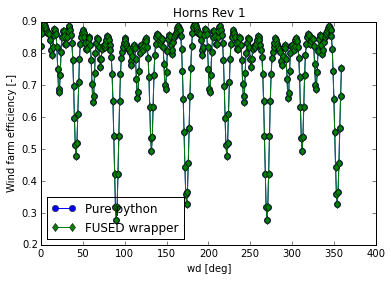

In [9]:
fig, ax = plt.subplots()
ax.plot(WD,P_WF/(HR1.WT.get_P(8.0)*HR1.nWT),'-o', label='Pure python')
ax.plot(WD,fP_WF/(HR1.WT.get_P(8.0)*HR1.nWT),'-d', label='FUSED wrapper')
ax.set_xlabel('wd [deg]')
ax.set_ylabel('Wind farm efficiency [-]')
ax.set_title(HR1.name)
ax.legend(loc=3)
plt.savefig(HR1.name+'_Power_wd_360.pdf')

## Asserting new implementation

In [12]:
WD = 261.05
P_WT,U_WT,CT_WT = GCLarsen_v0(WS=10.,z0=0.0001,TI=0.1,WD=WD,WF=HR1, NG=5, sup='quad')
P_WT_2,U_WT_2,CT_WT_2 = GCLarsen(WS=10.,z0=0.0001,TI=0.1,WD=WD,WF=HR1, NG=5, sup='quad')

In [13]:
np.testing.assert_array_almost_equal(U_WT,U_WT_2)
np.testing.assert_array_almost_equal(P_WT,P_WT_2)

AssertionError: 
Arrays are not almost equal to 6 decimals

(mismatch 90.0%)
 x: array([ 9.962871,  9.962871,  9.962871,  9.962871,  9.962871,  9.962871,
        9.962871,  9.962871,  9.641125,  9.641125,  9.641125,  9.641125,
        9.641125,  9.642529,  9.642529,  9.642529,  9.647347,  9.647347,...
 y: array([ 9.962871,  9.962871,  9.962871,  9.962871,  9.962871,  9.962871,
        9.962871,  9.962871,  9.637981,  9.637981,  9.637981,  9.637981,
        9.637981,  9.639397,  9.639397,  9.639397,  9.644347,  9.644347,...

There was a bug corrected in the new implementation of the GCL model

## Time comparison

New implementation is wrapped inside fusedwind

In [14]:
WD = range(0,360,1)

In [16]:
%%timeit
fP_WF = np.zeros([len(WD)])
for iwd, wd in enumerate(WD):
    fgcl.wind_direction = wd
    fgcl.run()
    fP_WF[iwd] = fgcl.power

1 loops, best of 3: 11.9 s per loop


In [17]:
%%timeit
#%%prun -s cumulative #profiling
P_WF = np.zeros([len(WD)])
for iwd, wd in enumerate(WD):
    P_WT,U_WT,CT_WT = GCLarsen(WS=8.0,z0=0.0001,TI=0.05,WD=wd,WF=HR1,NG=4,sup='lin')
    P_WF[iwd] = P_WT.sum()

1 loops, best of 3: 9.61 s per loop


## Pandas

In [18]:
df=pd.DataFrame(data=P_WF, index=WD, columns=['P_WF'])

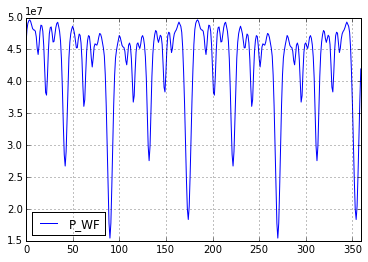

In [19]:
df.plot()

# WD uncertainty

Normally distributed wind direction uncertainty (reference wind direction, not for individual turbines).

In [20]:
P_WF_GAv8 = np.zeros([len(WD)])
P_WF_GAv16 = np.zeros([len(WD)])
for iwd, wd in enumerate(WD):
    P_WT_GAv,U_WT,CT_WT = GCL_P_GaussQ_Norm_U_WD(meanWD=wd,stdWD=2.5,NG_P=8, U0=8.0,z0=0.0001,TI=0.05,WF=HR1,NG=4,sup='lin')
    P_WF_GAv8[iwd] = P_WT_GAv.sum()
    P_WT_GAv,U_WT,CT_WT = GCL_P_GaussQ_Norm_U_WD(meanWD=wd,stdWD=2.5,NG_P=16, U0=8.0,z0=0.0001,TI=0.05,WF=HR1,NG=4,sup='lin')
    P_WF_GAv16[iwd] = P_WT_GAv.sum()


TypeError: GCL_P_GaussQ_Norm_U_WD() got an unexpected keyword argument 'U0'

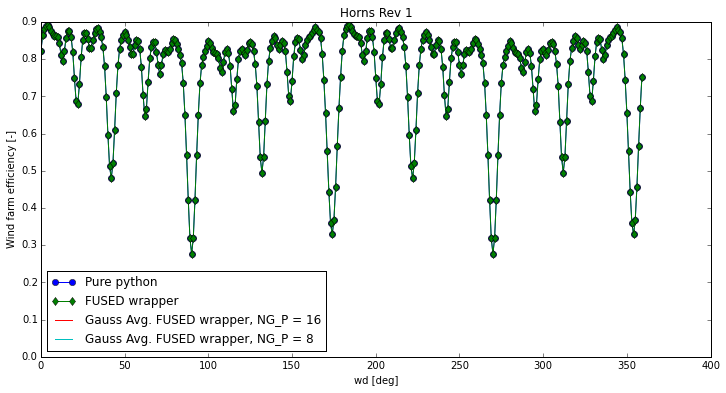

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches([12,6])
ax.plot(WD,P_WF/(HR1.WT.get_P(8.0)*HR1.nWT),'-o', label='Pure python')
ax.plot(WD,fP_WF/(HR1.WT.get_P(8.0)*HR1.nWT),'-d', label='FUSED wrapper')
ax.plot(WD,P_WF_GAv16/(HR1.WT.get_P(8.0)*HR1.nWT),'-', label='Gauss Avg. FUSED wrapper, NG_P = 16')
ax.plot(WD,P_WF_GAv8/(HR1.WT.get_P(8.0)*HR1.nWT),'-', label='Gauss Avg. FUSED wrapper, NG_P = 8')
ax.set_xlabel('wd [deg]')
ax.set_ylabel('Wind farm efficiency [-]')
ax.set_title(HR1.name)
ax.legend(loc=3)
plt.savefig(HR1.name+'_Power_wd_360.pdf')

Uniformly distributed wind direction uncertainty (bin/sectors definition)

In [24]:
P_WF_GA_u8 = np.zeros([len(WD)])
for iwd, wd in enumerate(WD):
    P_WT_GAv,U_WT,CT_WT = GCL_P_GaussQ_Uni_U_WD(meanWD=wd,U_WD=2.5,NG_P=8, WS=8.0,z0=0.0001,TI=0.05,WF=HR1,NG=4,sup='lin')
    P_WF_GA_u8[iwd] = P_WT_GAv.sum()


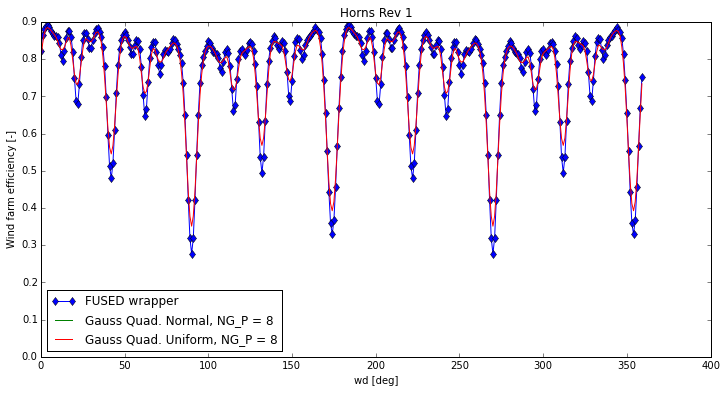

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches([12,6])
ax.plot(WD,fP_WF/(HR1.WT.get_P(8.0)*HR1.nWT),'-d', label='FUSED wrapper')
ax.plot(WD,P_WF_GAv8/(HR1.WT.get_P(8.0)*HR1.nWT),'-', label='Gauss Quad. Normal, NG_P = 8')
ax.plot(WD,P_WF_GA_u8/(HR1.WT.get_P(8.0)*HR1.nWT),'-', label='Gauss Quad. Uniform, NG_P = 8')
ax.set_xlabel('wd [deg]')
ax.set_ylabel('Wind farm efficiency [-]')
ax.set_title(HR1.name)
ax.legend(loc=3)
plt.savefig(HR1.name+'_Power_wd_360.pdf')